In [17]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import points_in_box
from enum import IntEnum
from typing import Tuple

import numpy as np
from pyquaternion import Quaternion

In [2]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/mike/workspaces/ECE579/data', verbose=True)

Loading NuScenes tables for version v1.0-trainval ...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 27.8 seconds.
Reverse indexing ...
Done reverse indexing in 6.9 seconds.


In [55]:
#Grab first scence
my_scene = nusc.scene[0]
#grab first sample from scene
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'e93e98b63d3b40209056d129dc53ceee',
 'timestamp': 1531883530449377,
 'prev': '',
 'next': '14d5adfe50bb4445bc3aa5fe607691a8',
 'scene_token': '73030fb67d3c46cfb5e590168088ae39',
 'data': {'RADAR_FRONT': 'bddd80ae33ec4e32b27fdb3c1160a30e',
  'RADAR_FRONT_LEFT': '1a08aec0958e42ebb37d26612a2cfc57',
  'RADAR_FRONT_RIGHT': '282fa8d7a3f34b68b56fb1e22e697668',
  'RADAR_BACK_LEFT': '05fc4678025246f3adf8e9b8a0a0b13b',
  'RADAR_BACK_RIGHT': '31b8099fb1c44c6381c3c71b335750bb',
  'LIDAR_TOP': '3388933b59444c5db71fade0bbfef470',
  'CAM_FRONT': '020d7b4f858147558106c504f7f31bef',
  'CAM_FRONT_RIGHT': '16d39ff22a8545b0a4ee3236a0fe1c20',
  'CAM_BACK_RIGHT': 'ec7096278e484c9ebe6894a2ad5682e9',
  'CAM_BACK': 'aab35aeccbda42de82b2ff5c278a0d48',
  'CAM_BACK_LEFT': '86e6806d626b4711a6d0f5015b090116',
  'CAM_FRONT_LEFT': '24332e9c554a406f880430f17771b608'},
 'anns': ['173a50411564442ab195e132472fde71',
  '5123ed5e450948ac8dc381772f2ae29a',
  'acce0b7220754600b700257a1de1573d',
  '8d7cb5e96cae48c39

In [153]:
#Grab first annotation from sample
samplenum=2
my_firstannotationToken = my_sample['anns'][samplenum]
my_firstannotationToken
nusc.get('sample_annotation',my_firstannotationToken)

{'token': 'acce0b7220754600b700257a1de1573d',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'instance_token': '39b6c31c9925492a8a9f1b0ef3b877b6',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [1002.464, 632.267, 1.936],
 'size': [2.312, 7.516, 3.093],
 'rotation': [0.9343569321017062, 0.0, 0.0, -0.35633849558178193],
 'prev': '',
 'next': '4b1c1acb00c04dfe84e54f64a8381649',
 'num_lidar_pts': 171,
 'num_radar_pts': 7,
 'category_name': 'vehicle.truck'}

In [154]:
nusc.list_sample(my_sample['token'])

Sample: e93e98b63d3b40209056d129dc53ceee

sample_data_token: bddd80ae33ec4e32b27fdb3c1160a30e, mod: radar, channel: RADAR_FRONT
sample_data_token: 1a08aec0958e42ebb37d26612a2cfc57, mod: radar, channel: RADAR_FRONT_LEFT
sample_data_token: 282fa8d7a3f34b68b56fb1e22e697668, mod: radar, channel: RADAR_FRONT_RIGHT
sample_data_token: 05fc4678025246f3adf8e9b8a0a0b13b, mod: radar, channel: RADAR_BACK_LEFT
sample_data_token: 31b8099fb1c44c6381c3c71b335750bb, mod: radar, channel: RADAR_BACK_RIGHT
sample_data_token: 3388933b59444c5db71fade0bbfef470, mod: lidar, channel: LIDAR_TOP
sample_data_token: 020d7b4f858147558106c504f7f31bef, mod: camera, channel: CAM_FRONT
sample_data_token: 16d39ff22a8545b0a4ee3236a0fe1c20, mod: camera, channel: CAM_FRONT_RIGHT
sample_data_token: ec7096278e484c9ebe6894a2ad5682e9, mod: camera, channel: CAM_BACK_RIGHT
sample_data_token: aab35aeccbda42de82b2ff5c278a0d48, mod: camera, channel: CAM_BACK
sample_data_token: 86e6806d626b4711a6d0f5015b090116, mod: camera, channel:

In [155]:
#Grab sensor data for sample
FCRadarData = nusc.get('sample_data', my_sample['data']['RADAR_FRONT'])
FLRadarData = nusc.get('sample_data', my_sample['data']['RADAR_FRONT_LEFT'])
FRRadarData = nusc.get('sample_data', my_sample['data']['RADAR_FRONT_RIGHT'])
RLRadarData = nusc.get('sample_data', my_sample['data']['RADAR_BACK_LEFT'])
RRRadarData = nusc.get('sample_data', my_sample['data']['RADAR_BACK_RIGHT'])

In [156]:
#GRAB Path to point clouds (pc_path), and all annotation boxes with this sensor data associated with them.
#Note that boxes are transformed into sensor frame, so we need a new list of boxes for each sensor
FC_pc_path, boxesFC, array = nusc.get_sample_data(FCRadarData['token'])
FL_pc_path, boxesFL, array = nusc.get_sample_data(FLRadarData['token'])
FR_pc_path, boxesFR, array = nusc.get_sample_data(FRRadarData['token'])
RL_pc_path, boxesRL, array = nusc.get_sample_data(RLRadarData['token'])
RR_pc_path, boxesRR, array = nusc.get_sample_data(RRRadarData['token'])

label: nan, score: nan, xyz: [17.01, 10.26, 0.97], wlh: [2.31, 7.52, 3.09], rot axis: [0.01, -0.01, 1.00], ang(degrees): -124.69, ang(rad): -2.18, vel: nan, nan, nan, name: vehicle.truck, token: acce0b7220754600b700257a1de1573d
label: nan, score: nan, xyz: [9.77, -17.63, 0.69], wlh: [2.31, 7.52, 3.09], rot axis: [0.00, -0.01, 1.00], ang(degrees): 146.40, ang(rad): 2.56, vel: nan, nan, nan, name: vehicle.truck, token: acce0b7220754600b700257a1de1573d
label: nan, score: nan, xyz: [-11.40, 17.77, 0.70], wlh: [2.31, 7.52, 3.09], rot axis: [0.04, 0.01, 1.00], ang(degrees): -33.59, ang(rad): -0.59, vel: nan, nan, nan, name: vehicle.truck, token: acce0b7220754600b700257a1de1573d
label: nan, score: nan, xyz: [-19.89, -11.53, 0.94], wlh: [2.31, 7.52, 3.09], rot axis: [-0.01, -0.02, 1.00], ang(degrees): 60.68, ang(rad): 1.06, vel: nan, nan, nan, name: vehicle.truck, token: acce0b7220754600b700257a1de1573d
label: nan, score: nan, xyz: [-21.57, -9.25, 0.94], wlh: [2.31, 7.52, 3.09], rot axis: [0.0

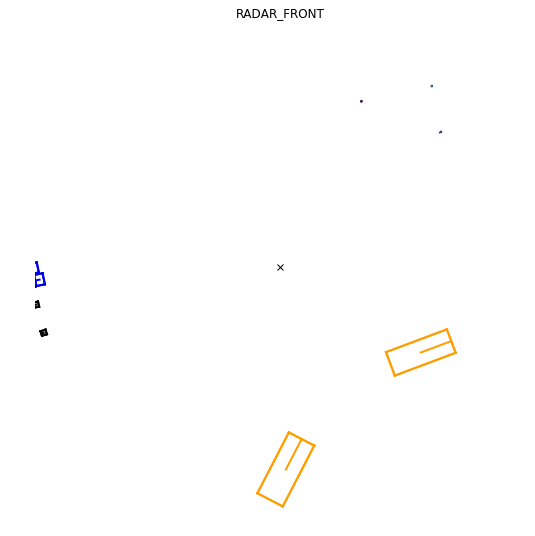

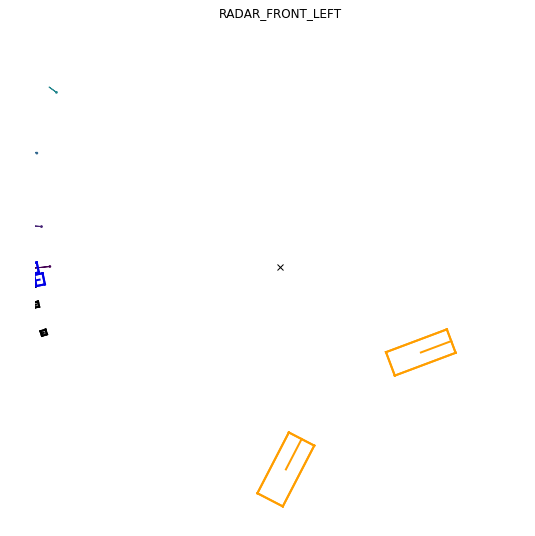

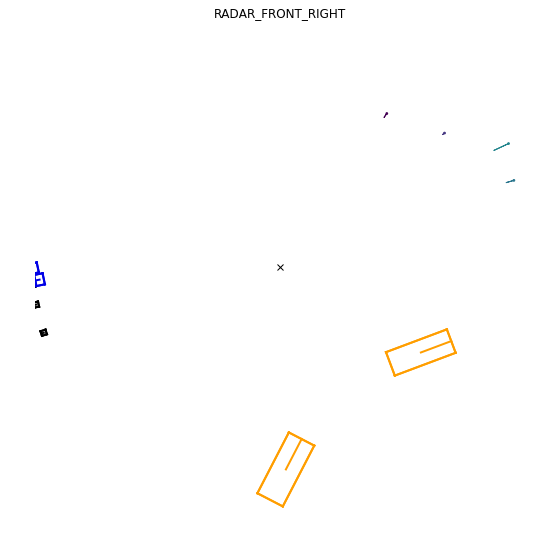

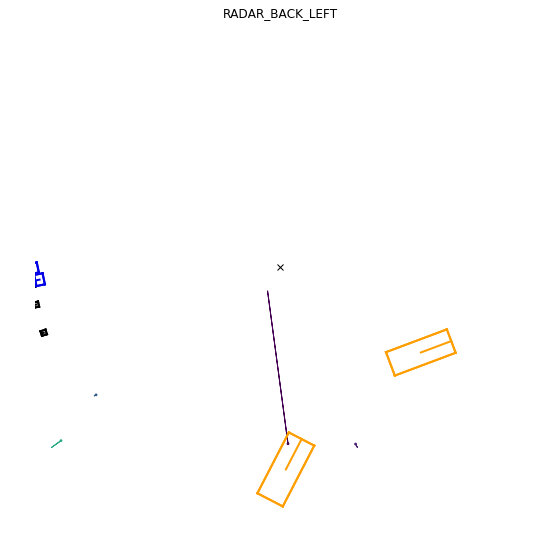

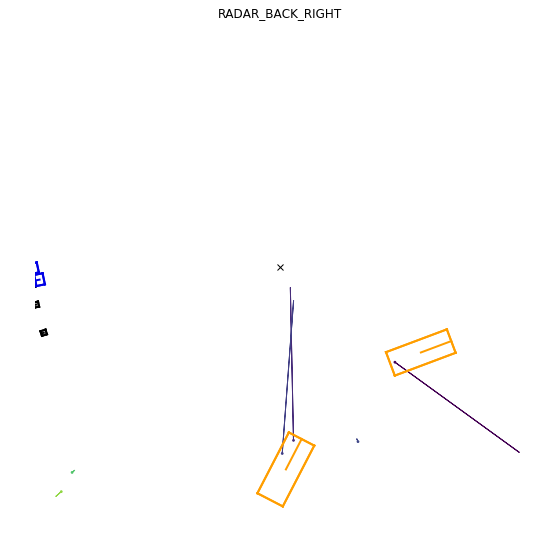

In [157]:
#Check to see if each box from each box list is the same annotation
mybox_FC = boxesFC[samplenum]
print(mybox_FC)
mybox_FL = boxesFL[samplenum]
print(mybox_FL)
mybox_FR = boxesFR[samplenum]
print(mybox_FR)
mybox_RL = boxesRL[samplenum]
print(mybox_RL)
mybox_RR = boxesRR[samplenum]
print(mybox_RR)
myannoFC=nusc.get('sample_annotation',mybox_FC.token)
myannoFL=nusc.get('sample_annotation',mybox_FL.token)
myannoFR=nusc.get('sample_annotation',mybox_FR.token)
myannoRL=nusc.get('sample_annotation',mybox_RL.token)
myannoRR=nusc.get('sample_annotation',mybox_RR.token)

print(myannoFC ==myannoFL ==myannoFR ==myannoRL== myannoRR)
print(myannoRR)

nusc.render_sample_data(FCRadarData['token'],axes_limit =16,nsweeps=2)
nusc.render_sample_data(FLRadarData['token'],axes_limit =16,nsweeps=2)
nusc.render_sample_data(FRRadarData['token'],axes_limit =16,nsweeps=2)
nusc.render_sample_data(RLRadarData['token'],axes_limit =16,nsweeps=2)
nusc.render_sample_data(RRRadarData['token'],axes_limit =16,nsweeps=2)
#nusc.get('sample_annotation',my_firstannotationToken)

In [158]:
FC_pc = RadarPointCloud.from_file(FC_pc_path)
FL_pc = RadarPointCloud.from_file(FL_pc_path)
FR_pc = RadarPointCloud.from_file(FR_pc_path)
RL_pc = RadarPointCloud.from_file(RL_pc_path)
RR_pc = RadarPointCloud.from_file(RR_pc_path)
print(FC_pc.nbr_points())
print(FL_pc.nbr_points())
print(FR_pc.nbr_points())
print(RL_pc.nbr_points())
print(RR_pc.nbr_points())

36
34
10
54
63


In [159]:
invalids=[0x00,0x01,0x02,0x03,0x05,0x06,0x07,0x0d,0x0e,0x04,0x08,0x09,0x0a,0x0b,0x0c,0x0f,0x10,0x11]
FC_pc = RadarPointCloud.from_file(FC_pc_path,invalid_states=invalids,ambig_states=range(4))
FC_pc = RadarPointCloud.from_file(FC_pc_path,invalid_states=invalids,ambig_states=range(4))
FL_pc = RadarPointCloud.from_file(FL_pc_path,invalid_states=invalids,ambig_states=range(4))
FR_pc = RadarPointCloud.from_file(FR_pc_path,invalid_states=invalids,ambig_states=range(4))
RL_pc = RadarPointCloud.from_file(RL_pc_path,invalid_states=invalids,ambig_states=range(4))
RR_pc = RadarPointCloud.from_file(RR_pc_path,invalid_states=invalids,ambig_states=range(4))
print(FC_pc2.nbr_points())
print(FL_pc2.nbr_points())
print(FR_pc2.nbr_points())
print(RL_pc2.nbr_points())
print(RR_pc2.nbr_points())

88
104
43
125
125


In [160]:
FC_points = np.array(FC_pc.points[:3, :])
#FC_points = FC_points.reshape(3,FC_pc.nbr_points())
FL_points = FL_pc.points[:3, :]
FL_points = FL_points.reshape(3,FL_pc.nbr_points())
FR_points = FR_pc.points[:3, :]
FR_points = FR_points.reshape(3,FR_pc.nbr_points())
RL_points = RL_pc.points[:3, :]
RL_points = RL_points.reshape(3,RL_pc.nbr_points())
RR_points = RR_pc.points[:3, :]
RR_points = RR_points.reshape(3,RR_pc.nbr_points())
FC_points

array([[  8.39999962,   6.4000001 ,   9.39999962,  14.60000038,
         15.        ,  14.        ,  15.60000038,  17.20000076,
         16.39999962,  16.39999962,  18.20000076,  16.20000076,
         17.79999924,  19.60000038,  17.39999962,  21.20000076,
         17.        ,  17.39999962,  17.79999924,  21.79999924,
         22.39999962,  24.        ,  23.        ,  25.79999924,
         24.        ,  21.20000076,  22.20000076,  28.20000076,
         29.39999962,  22.79999924,  23.79999924,  30.39999962,
         24.        ,  31.79999924,  32.59999847,  35.        ,
         35.40000153,  36.40000153,  36.79999924,  36.79999924,
         37.        ,  37.59999847,  16.60000038,  38.40000153,
         39.59999847,  34.59999847,  32.40000153,  39.79999924,
         31.39999962,  43.20000076,  39.59999847,  40.40000153,
         31.20000076,  31.79999924,  33.        ,  57.20000076,
         59.20000076,  55.79999924,  36.40000153,  37.20000076,
         46.20000076,  66.59999847,  67.

In [161]:
print(sum(i==True for i in points_in_box(mybox_FC, FC_points)))
print(sum(i==True for i in points_in_box(mybox_FL, FL_points)))
print(sum(i==True for i in points_in_box(mybox_FR, FR_points)))
print(sum(i==True for i in points_in_box(mybox_RL, RL_points)))
print(sum(i==True for i in points_in_box(mybox_RR, RR_points)))

6
1
0
0
0


In [140]:
points = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]).transpose()
points

array([[0. , 0.5],
       [0. , 0.5],
       [0. , 0. ]])

In [141]:
corner=mybox_FC.corners(wlh_factor=1)
corner

array([[ -6.49220485,  -8.02492755,  -8.05775757,  -6.52503488,
         -7.98813888,  -9.52086157,  -9.5536916 ,  -8.0209689 ],
       [-10.90555938, -11.48225369, -11.48250693, -10.90581262,
         -6.92767491,  -7.50436922,  -7.50462246,  -6.92792815],
       [  1.02354089,   1.0585954 ,  -0.38103029,  -0.4160848 ,
          1.05695527,   1.09200977,  -0.34761592,  -0.38267042]])